In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from scipy.signal import find_peaks, argrelextrema,argrelmax,argrelmin
import scipy.stats as stats
from scipy.stats import genextreme as gev
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import cmaps
from xhistogram.xarray import histogram
import rpy2
from rpy2.robjects.packages import importr, data
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
from rpy2.robjects import globalenv
pandas2ri.activate()

extRemes = importr("extRemes")
evgam = importr("evgam")
%load_ext rpy2.ipython

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("cma.mplstyle")

In [4]:
yearb=1980
yeare=2008

files=[f'../AFI/AFI_ERA5_{iyear}_fullUSA_method3.nc' for iyear in range(yearb,yeare+1)]

ds=xr.open_mfdataset(files)

return_periods=[2, 5, 10, 25, 50, 100]
Tlon=ds.lon.data
Tlat=ds.lat.data

units='degree-days (°F)'

In [5]:
dsm=xr.open_dataset('../AFI/ERA5_air.2m.DJFclim.nc')
dsm=dsm.drop('season')
ds=ds.merge({'air':dsm['air']})

dsh=xr.open_dataset('../AFI/ERA5_hgt.sfc.nc')

/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_8176/2759387416.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  dsm=dsm.drop('season')


In [6]:
ptlon=[260,270,264.25,241,205,204]
ptlat=[41,40,37,46.25,68.75,60]

Text(0.5, 0.98, 'AFI mean (1980-2009)')

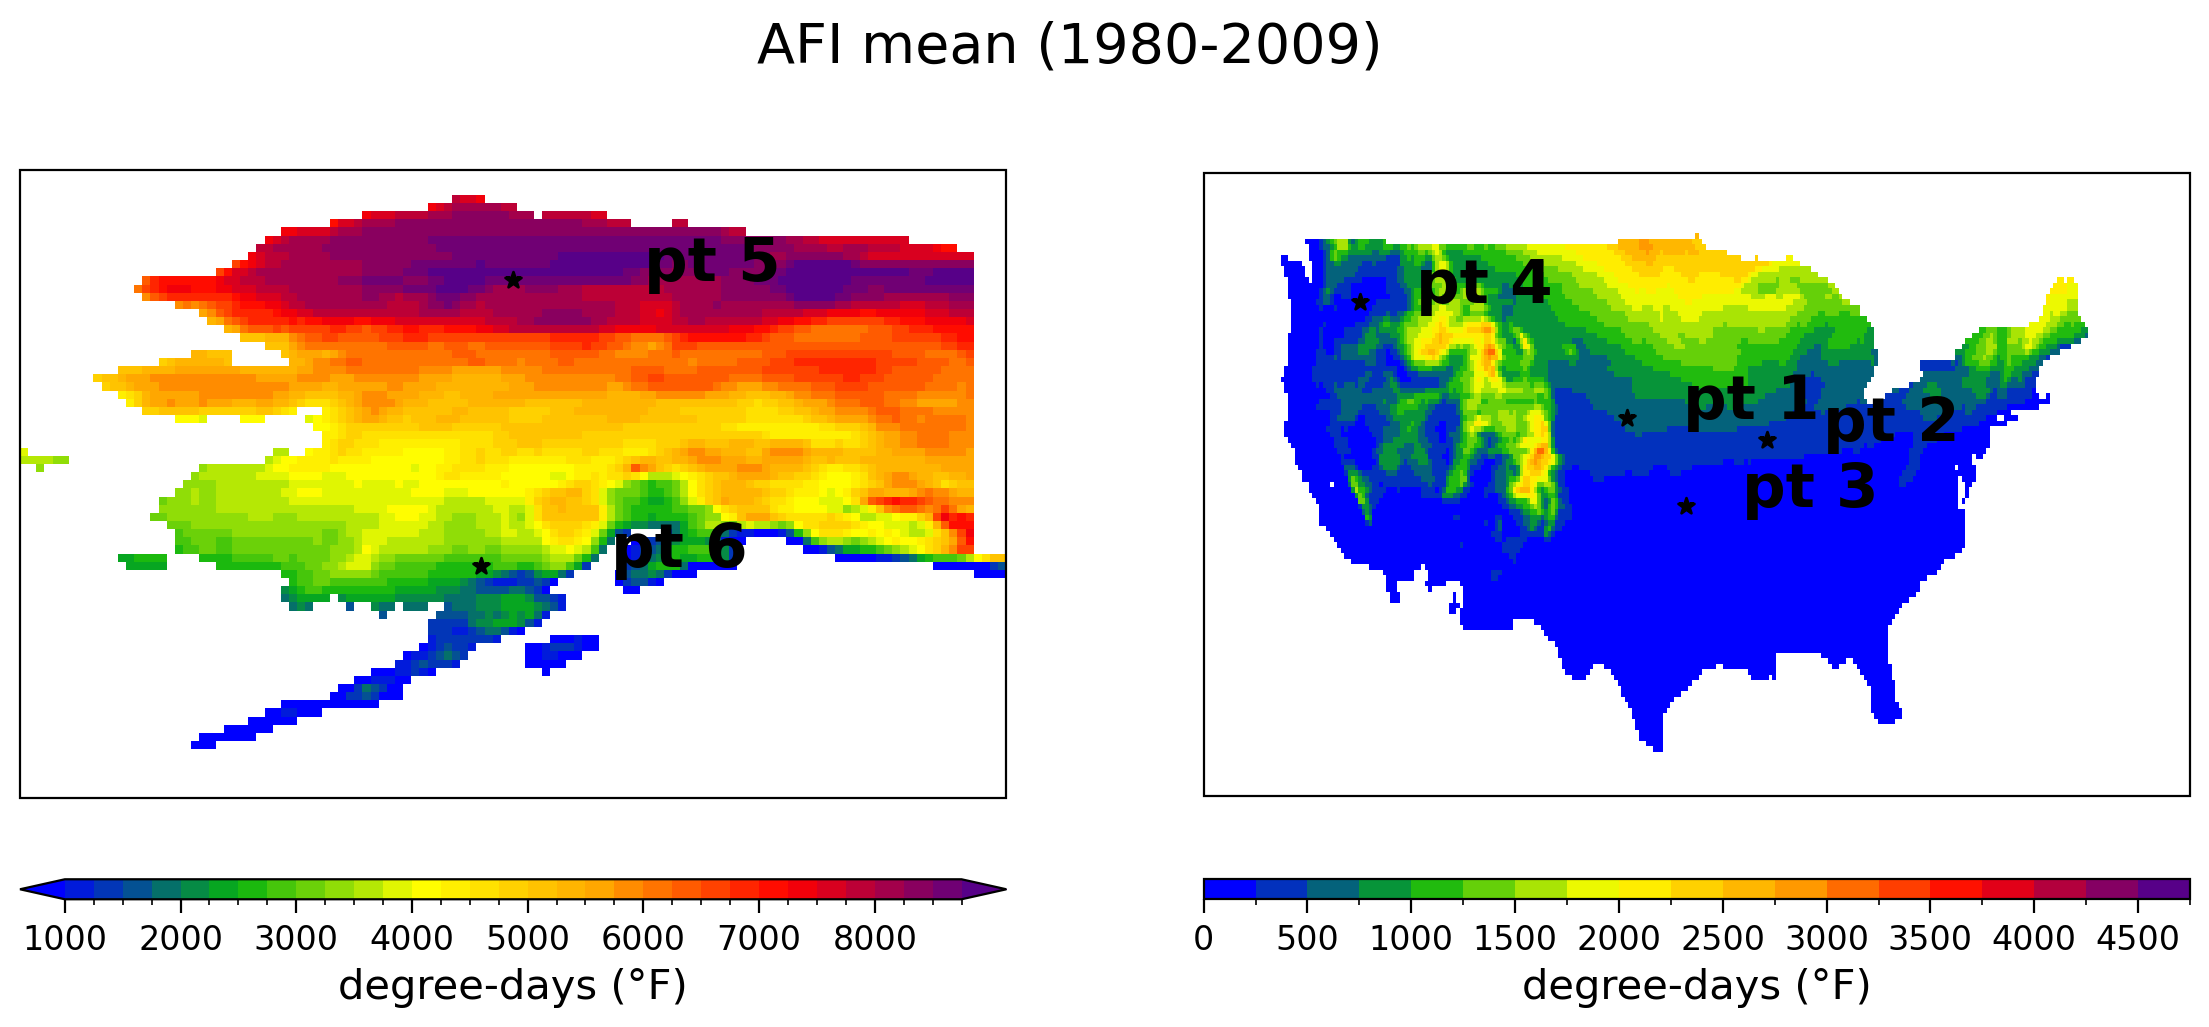

In [7]:
cmap=cmaps.BlGrYeOrReVi200
proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,5),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.9)

cc=ds['AFI'].where(ds['AFI']>0.).mean('time').sel(lon=slice(190,220),lat=slice(72,53)).plot(ax=ax[0],cmap=cmap,levels=np.arange(1000,9000,250),add_colorbar=False)
for ip in range(4,6):
  ax[0].scatter(ptlon[ip],ptlat[ip],marker='*',color='k')
  ax[0].text(ptlon[ip]-360+4,ptlat[ip],f'pt {ip+1}',color='k',size=22,weight='bold')
p0 = ax[0].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.1, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,\
        shrink=0.5,\
        orientation='horizontal',label=units)
cbar.ax.tick_params(labelsize=12)

cc=ds['AFI'].where(ds['AFI']>0.).mean('time').sel(lon=slice(230,300),lat=slice(52,22)).plot(ax=ax[1],cmap=cmap,levels=np.arange(0,5000,250),add_colorbar=False)
for ip in range(0,4):
  ax[1].scatter(ptlon[ip],ptlat[ip],marker='*',color='k')
  ax[1].text(ptlon[ip]-360+4,ptlat[ip],f'pt {ip+1}',color='k',size=22,weight='bold')
p0 = ax[1].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], 0.1, p0[2]-p0[0], 0.02])
cbar=fig.colorbar(cc,cax=ax_cbar,\
        shrink=0.5,\
        orientation='horizontal',label=units)
cbar.ax.tick_params(labelsize=12)

asp = np.diff(ax[0].get_xlim())[0] / np.diff(ax[0].get_ylim())[0]
ax[1].set_aspect(asp)
plt.suptitle('AFI mean (1980-2009)', fontsize=20)

# Pt 1

In [24]:
ij=0
ilon=254#ptlon[ij]
ilat=40#ptlat[ij]
dsij=ds.sel(lon=slice(ilon-4,ilon+4),lat=slice(ilat+4,ilat-4)).load()
dsmij=dsm.sel(lon=slice(ilon-4,ilon+4),lat=slice(ilat+4,ilat-4))

In [30]:
dsij

<xarray.Dataset> Size: 262kB
Dimensions:  (time: 29, lat: 33, lon: 33)
Coordinates:
  * time     (time) int64 232B 1980 1981 1982 1983 1984 ... 2005 2006 2007 2008
  * lat      (lat) float64 264B 44.0 43.75 43.5 43.25 ... 36.75 36.5 36.25 36.0
  * lon      (lon) float64 264B 250.0 250.2 250.5 250.8 ... 257.5 257.8 258.0
Data variables:
    AFI      (time, lat, lon) float64 253kB 2.38e+03 2.622e+03 ... 39.33 41.95
    air      (lat, lon) float64 9kB 262.1 261.3 261.4 ... 275.7 275.6 275.8

In [25]:
df = dsij.to_dataframe()
# Remove zeros if any (as in Bilotta et al.)
df = df[df['AFI'] > 0.]
df = df.reset_index()

dfm=dsmij.to_dataframe()
dfm=dfm.reset_index()
# Convert pandas DataFrame to R data.frame
r_df = ro.conversion.py2rpy(df)
r_dfm=ro.conversion.py2rpy(dfm)

# You can now work with 'r_df' in R
print('r_df summary')
print(ro.r['summary'](r_df))
globalenv['r_df'] = r_df
globalenv['r_dfm'] = r_dfm

r_df summary
['Min.   :1980  ' '1st Qu.:1987  ' 'Median :1994  ' 'Mean   :1994  '
 '3rd Qu.:2001  ' 'Max.   :2008  ' 'Min.   :36  ' '1st Qu.:38  '
 'Median :40  ' 'Mean   :40  ' '3rd Qu.:42  ' 'Max.   :44  '
 'Min.   :250  ' '1st Qu.:252  ' 'Median :254  ' 'Mean   :254  '
 '3rd Qu.:256  ' 'Max.   :258  ' 'Min.   :   2.664  ' '1st Qu.: 312.473  '
 'Median : 765.780  ' 'Mean   : 917.112  ' '3rd Qu.:1401.035  '
 'Max.   :3784.191  ' 'Min.   :261.3  ' '1st Qu.:266.1  '
 'Median :269.0  ' 'Mean   :268.8  ' '3rd Qu.:271.7  ' 'Max.   :275.8  ']


<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_8176/802269699.py:11: SyntaxWarning: invalid escape sequence '\d'
  ax[1].set_title('DJF Temp ($\degree$C)',fontsize=14)
/var/folders/2z/v4x6xdj96rg1k3xrmwt26xtc0000gp/T/ipykernel_8176/802269699.py:14: SyntaxWarning: invalid escape sequence '\d'
  ax[2].set_title('mean AFI ($\degree$-days(F))',fontsize=14)


Text(0.5, 1.0, 'mean AFI ($\\degree$-days(F))')

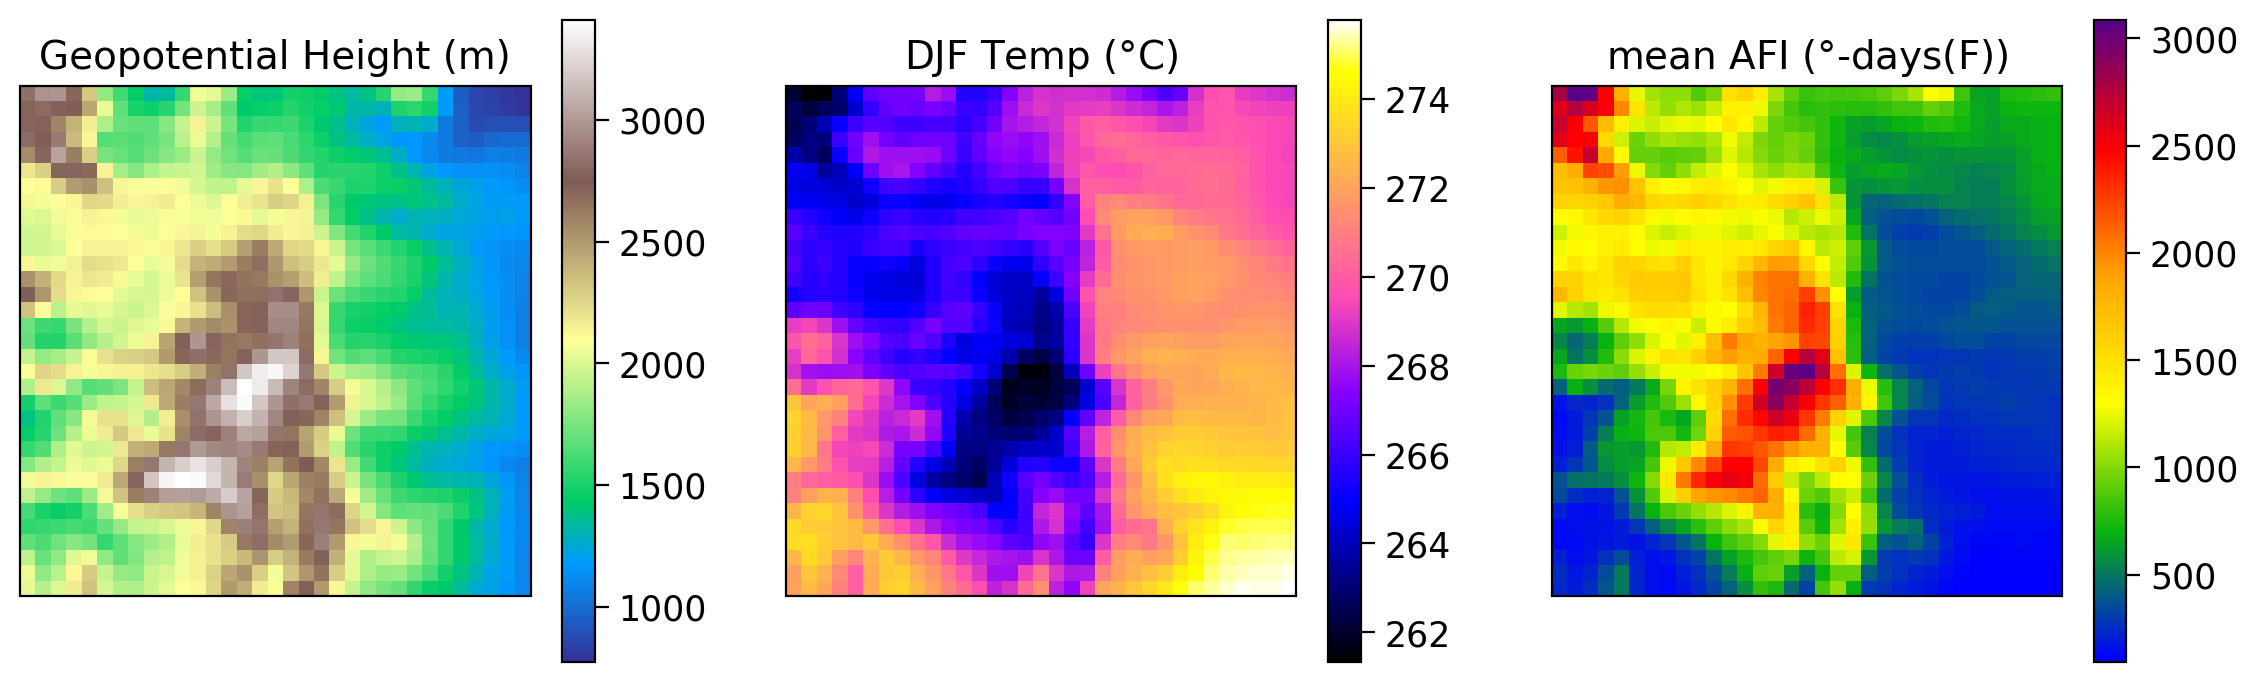

In [27]:
cmap=cmaps.BlGrYeOrReVi200
proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(14,8),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.9)

dsh['hgt'].sel(lon=slice(ilon-4,ilon+4),lat=slice(ilat+4,ilat-4)) \
    .plot(ax=ax[0],cmap='terrain',cbar_kwargs={'label':'','shrink':0.55})
ax[0].set_title('Geopotential Height (m)',fontsize=14)

dsmij['air'].plot(ax=ax[1],cmap='gnuplot2',cbar_kwargs={'label':'','shrink':0.55})
ax[1].set_title('DJF Temp ($\degree$C)',fontsize=14)

dsij['AFI'].mean('time').plot(ax=ax[2],cmap=cmap,cbar_kwargs={'label':'','shrink':0.55})
ax[2].set_title('mean AFI ($\degree$-days(F))',fontsize=14)

# Parameters for smoothness:<br>
The next step is to provide formulae for smooths to pass to mgcv::s(). 
A spatial model will be fitted that allows spatial variation in the GEV’s location and scale parameters. <br>
Spatial variation is achieved with thin plate regression splines, which are mgcv::s()’s default. <br>
The basis dimension, k, has been specified to differ with GEV parameter. 
The GEV’s shape parameter is assumed constant. 
The value of k caps a smooth’s degrees of freedom, and hence, in some sense, its ultimate wiggliness. <br>
In practice, k should be chosen larger than a smooth’s expected degrees of freedom so that the smoothing parameters control the effective degrees of freedom. The GEV’s location parameter also includes a smooth in elev, station elevation. This is specified as a cubic regression spline, bs = "cr", with k left at its default.<br>
<br>
The example given is : <br>
fmla_gev <- list(prcp ~ s(lon, lat, k = 30) + s(elev, bs = "cr"), ~ s(lon, lat, k = 20), ~ 1)

GH: I have been playing with those different parameters to see how they are affecting our results.

In [28]:
#%R fmla_gev <- list(AFI ~ s(lon, lat, k = 30) + s(hgt, bs = "cr"), ~ s(lon, lat, k = 20), ~ 1)
%R fmla_gev <- list(AFI ~ s(lon, lat, k = 30) +  s(air, bs = "cr"), ~ s(lon, lat, k = 30) + s(air, bs = "cr"), ~ s(air, bs = "cr"))
#%R fmla_gev <- list(AFI ~ s(air, bs = "cr"), ~ s(air, bs = "cr"), ~ s(air, bs = "cr"))

o{'None': AFI ~ s(lon, lat, k = 30) + s(air, bs = "cr")
, 'None': ~s(lon, lat, k = 30) + s(air, bs = "cr")
, 'None': ~s(air, bs = "cr")
, }

# Model fitting <br>
The necessity of smooths can be checked through p values. In this example they are all
≪0.01, indicating the smooths are beneficial. All one- or two-dimensional smooths can be
viewed with plot(), i.e.,

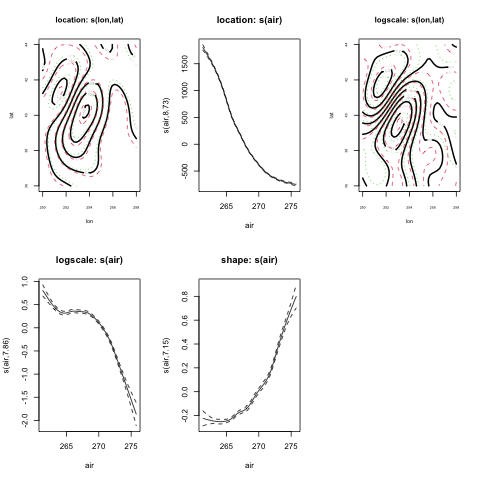

In [29]:
%R m_gev <- evgam(fmla_gev, r_df, family = "gev")
%R plot(m_gev)

In [31]:
%R summary(m_gev)

o{'None': o{'location':                Estimate  Std. Error    t value  Pr(>|t|)
(Intercept)  818.372631    1.709874  478.61572       0.0, 'logscale':              Estimate  Std. Error      t value  Pr(>|t|)
(Intercept)  5.411051    0.004982  1086.153037       0.0, 'shape':              Estimate  Std. Error    t value       Pr(>|t|)
(Intercept) -0.151242    0.004661 -32.448297  2.862285e-231, }, 'None': o{'location':                   edf  max.df        Chi.sq       Pr(>|t|)
s(lon,lat)  27.655910      29   1020.257045  2.608997e-182
s(air)       8.732788       9  23508.252839   0.000000e+00, 'logscale':                   edf  max.df       Chi.sq       Pr(>|t|)
s(lon,lat)  27.151480      29  1819.136473   0.000000e+00
s(air)       7.864535       9  1009.283378  1.721913e-209, 'shape':              edf  max.df       Chi.sq  Pr(>|t|)
s(air)  7.154438       9  2341.992108       0.0, }, }

In [32]:
%R -o m_gev

Often predictions are sought from a fitted model. These are
achieved with predict(). Predictions for the GEV’s three parameters for COprcp_plot can
be obtained with

In [33]:
%R gev_pred <- predict(m_gev, r_dfm, type = "response")
%R -o gev_pred,r_dfm

In [34]:
gev_pred['lon']=r_dfm['lon']
gev_pred['lat']=r_dfm['lat']
dsgev_pred=gev_pred.set_index(['lat','lon']).to_xarray()

# 100-year return level <br>
This is an estimate of the 0.99 quantile of the distribution of the annual
maximum for each location and achieved with

In [35]:
%R gev_rl100 <- predict(m_gev, r_dfm, prob = 0.99)
%R -o gev_rl100

In [36]:
gev_rl100['lon']=r_dfm['lon']
gev_rl100['lat']=r_dfm['lat']
dsgev_rl100=gev_rl100.set_index(['lat','lon']).to_xarray()

In [37]:
print(dsgev_pred['location'].min(),dsgev_pred['location'].max())
print(dsgev_pred['shape'].min(),dsgev_pred['shape'].max())
print(dsgev_pred['scale'].min(),dsgev_pred['scale'].max())
print(dsgev_rl100['q:0.99'].min(),dsgev_rl100['q:0.99'].max())

<xarray.DataArray 'location' ()> Size: 8B
array(41.15925784) <xarray.DataArray 'location' ()> Size: 8B
array(2718.11281942)
<xarray.DataArray 'shape' ()> Size: 8B
array(-0.40266689) <xarray.DataArray 'shape' ()> Size: 8B
array(0.64983361)
<xarray.DataArray 'scale' ()> Size: 8B
array(36.8046052) <xarray.DataArray 'scale' ()> Size: 8B
array(610.86728178)
<xarray.DataArray 'q:0.99' ()> Size: 8B
array(0.) <xarray.DataArray 'q:0.99' ()> Size: 8B
array(3961.93844066)


Text(0.5, 1.0, '100−year return level')

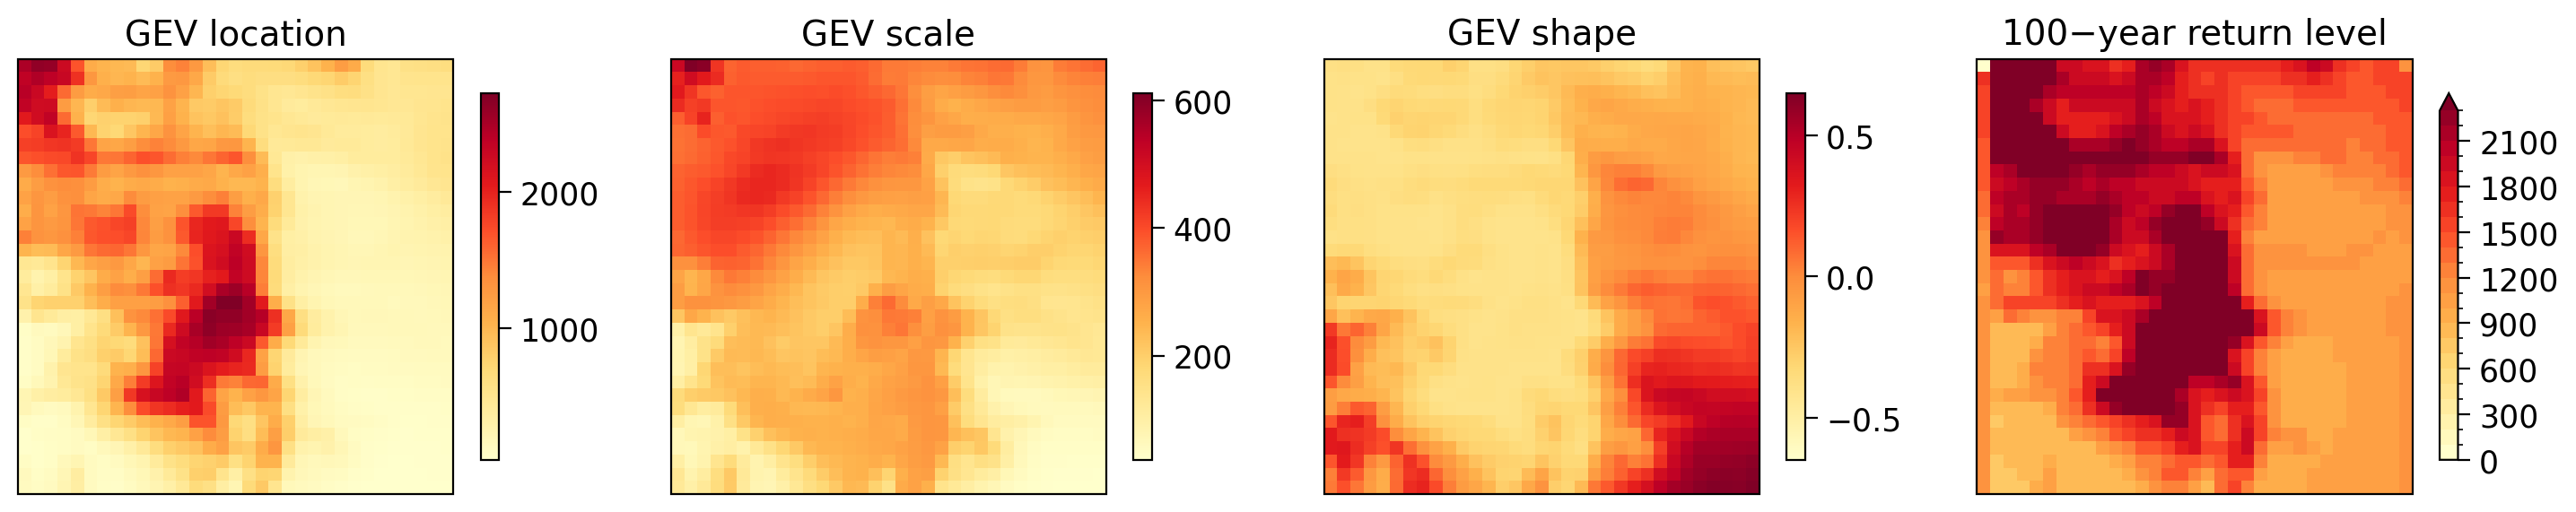

In [38]:

proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(18,8),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.9,wspace=0.2)

dsgev_pred['location'].plot(ax=ax[0],cmap='YlOrRd',cbar_kwargs={'label':'','shrink':0.35})
ax[0].set_title('GEV location',fontsize=14)

dsgev_pred['scale'].plot(ax=ax[1],cmap='YlOrRd',cbar_kwargs={'label':'','shrink':0.35})
ax[1].set_title('GEV scale',fontsize=14)

dsgev_pred['shape'].plot(ax=ax[2],cmap='YlOrRd',cbar_kwargs={'label':'','shrink':0.35})
ax[2].set_title('GEV shape',fontsize=14)

dsgev_rl100['q:0.99'].plot(ax=ax[3],cmap='YlOrRd',levels=np.arange(0,2400,100),cbar_kwargs={'label':'','shrink':0.35})
ax[3].set_title('100−year return level',fontsize=14)

# Compute GEV parameters with scipy.stats.

In [39]:
return_period = [2, 5, 10, 25, 50, 100]
rp = return_period[-1]
Tlocation = xr.zeros_like(dsmij['air'])*np.nan
Tshape = xr.zeros_like(dsmij['air'])*np.nan
Tscale = xr.zeros_like(dsmij['air'])*np.nan
Trl100 = xr.zeros_like(dsmij['air'])*np.nan
for j in range(0,len(dsij['lat'])):
  for i in range(0,len(dsij['lon'])):
     data = dsij['AFI'].isel(lon=i,lat=j)
     afi_values = data.values
     # Remove zeros if any (as in Bilotta et al.)
     nonzero_afis = afi_values[afi_values > 0]
     shape, loc, scale = gev.fit(data.where(data>0), loc=nonzero_afis.mean(), scale=nonzero_afis.std(),method="MLE")
     Tshape[j,i] = shape
     Tlocation[j,i] = loc
     Tscale[j,i] = scale
     p = 1 - 1/rp
     # Get the AFI value for this return period
     Trl100[j,i] = stats.genextreme.ppf(p, shape, loc, scale)

# Difference between the 2 methods. 

In [42]:
Trl100

<xarray.DataArray 'air' (lat: 33, lon: 33)> Size: 9kB
array([[3436.50583345, 3744.99317806, 3743.21908126, ..., 2023.42292733,
        2076.40301574, 2107.75372399],
       [3264.94909767, 3436.55461079, 3294.05182355, ..., 2117.96730489,
        2139.58875573, 2025.97719108],
       [3324.62457392, 3178.4290207 , 2877.91682519, ..., 1743.05462129,
        2220.75390019, 2030.98829847],
       ...,
       [1058.48730189,  947.75941966,  911.49125222, ..., 1078.67213507,
         990.80218135,  785.57468027],
       [ 978.71740011, 1046.57769303,  843.41318181, ...,  892.89132837,
         942.43479808,  847.23760173],
       [1036.0706157 ,  952.2003993 ,  737.02521141, ...,  918.21332031,
         868.40076894,  740.67166195]], shape=(33, 33))
Coordinates:
  * lat      (lat) float64 264B 44.0 43.75 43.5 43.25 ... 36.75 36.5 36.25 36.0
  * lon      (lon) float64 264B 250.0 250.2 250.5 250.8 ... 257.5 257.8 258.0

Text(0.5, 1.0, '100−year return level: Scipy - Evgam')

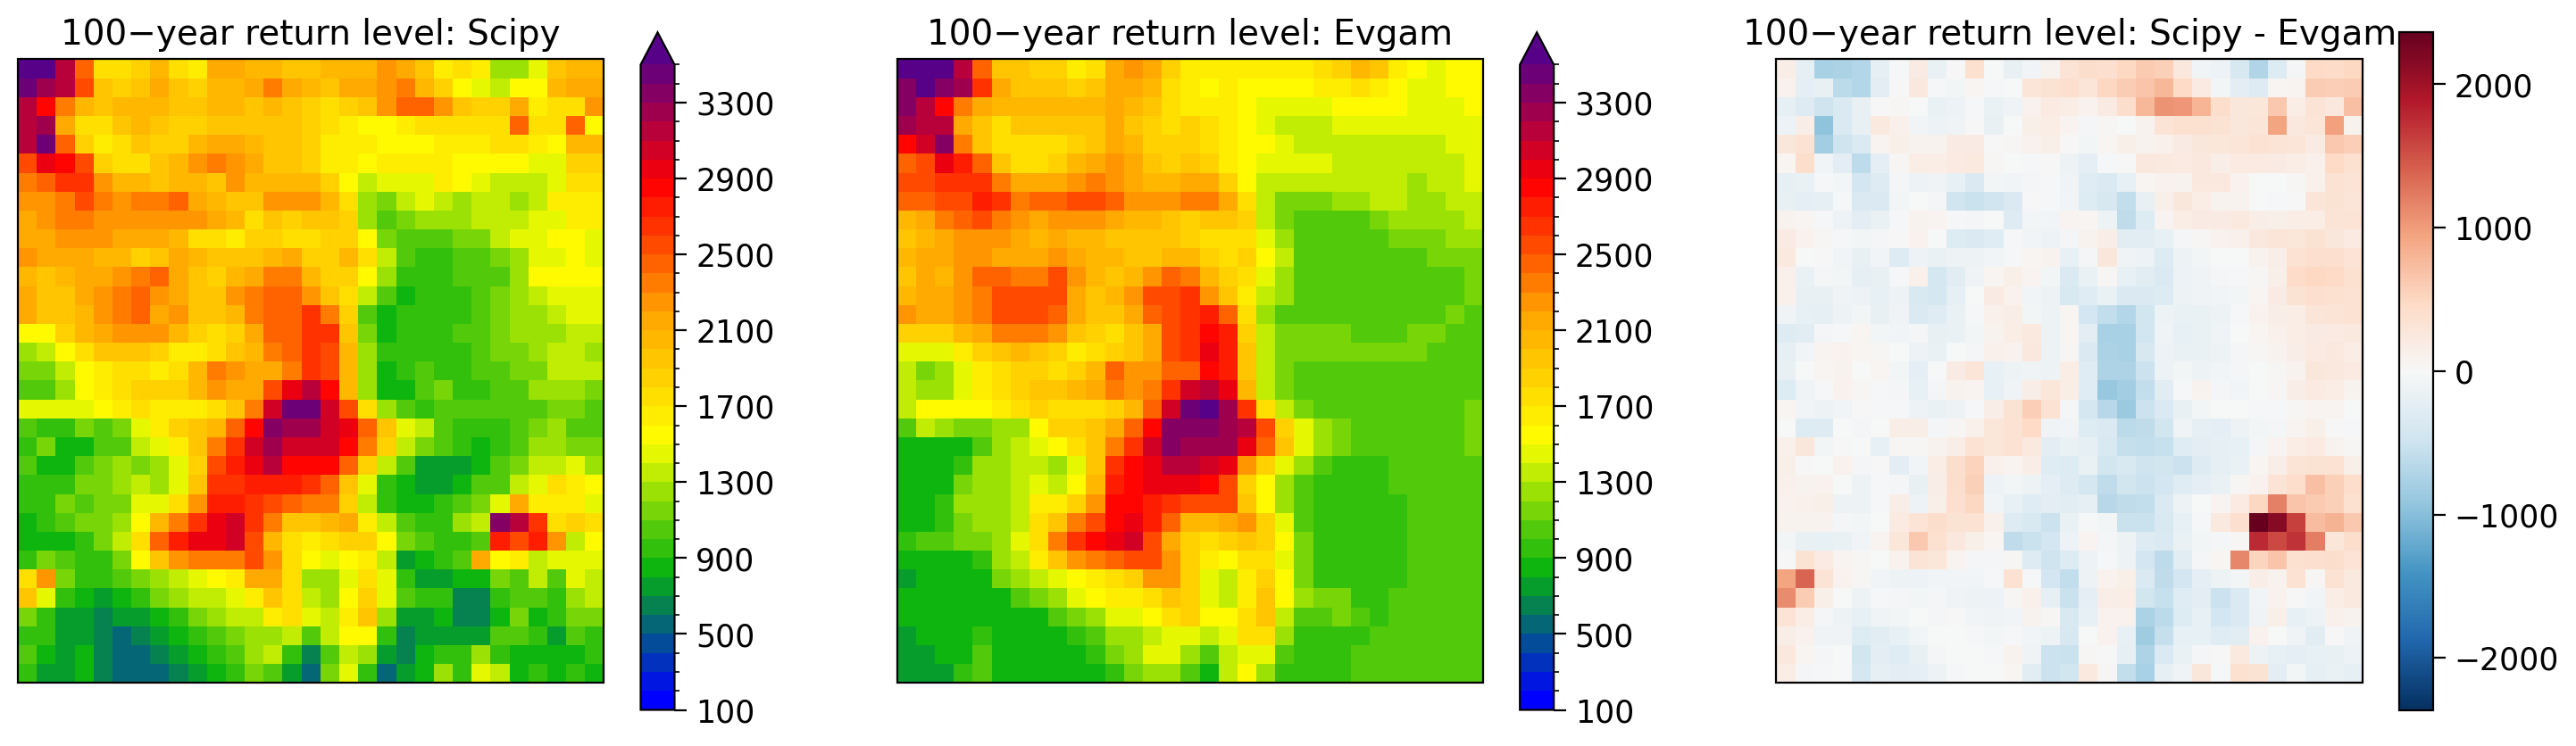

In [43]:
proj=ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(18,8),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.15, right=0.9,hspace=0.15)
#
data=Trl100
data=data.isel(lon=slice(1,32))
data.plot(ax=ax[0],cmap=cmap,levels=np.arange(100,3600,100),cbar_kwargs={'label':'','shrink':0.65})
ax[0].set_title('100−year return level: Scipy',fontsize=14)
#
data=dsgev_rl100['q:0.99']
data=data.isel(lon=slice(1,32))
data.plot(ax=ax[1],cmap=cmap,levels=np.arange(100,3600,100),cbar_kwargs={'label':'','shrink':0.65})
#ax[1].contour(dsij['lon'].isel(lon=slice(1,19)),dsij['lat'],dsij['AFI'].mean('time').isel(lon=slice(1,19)),color='k')
ax[1].set_title('100−year return level: Evgam',fontsize=14)
#
data=(Trl100-dsgev_rl100['q:0.99'])
data=data.isel(lon=slice(1,32))
data.plot(ax=ax[2],cbar_kwargs={'label':'','shrink':0.65})
#ax[2].contour(data['lon'],data['lat'],dsmij['air'].isel(lon=slice(1,19)),cmap='terrain')
ax[2].set_title('100−year return level: Scipy - Evgam',fontsize=14)


The 100-year return level is expressed in degree-days (F).

Text(0.5, 0.98, 'Scipy - Evgam')

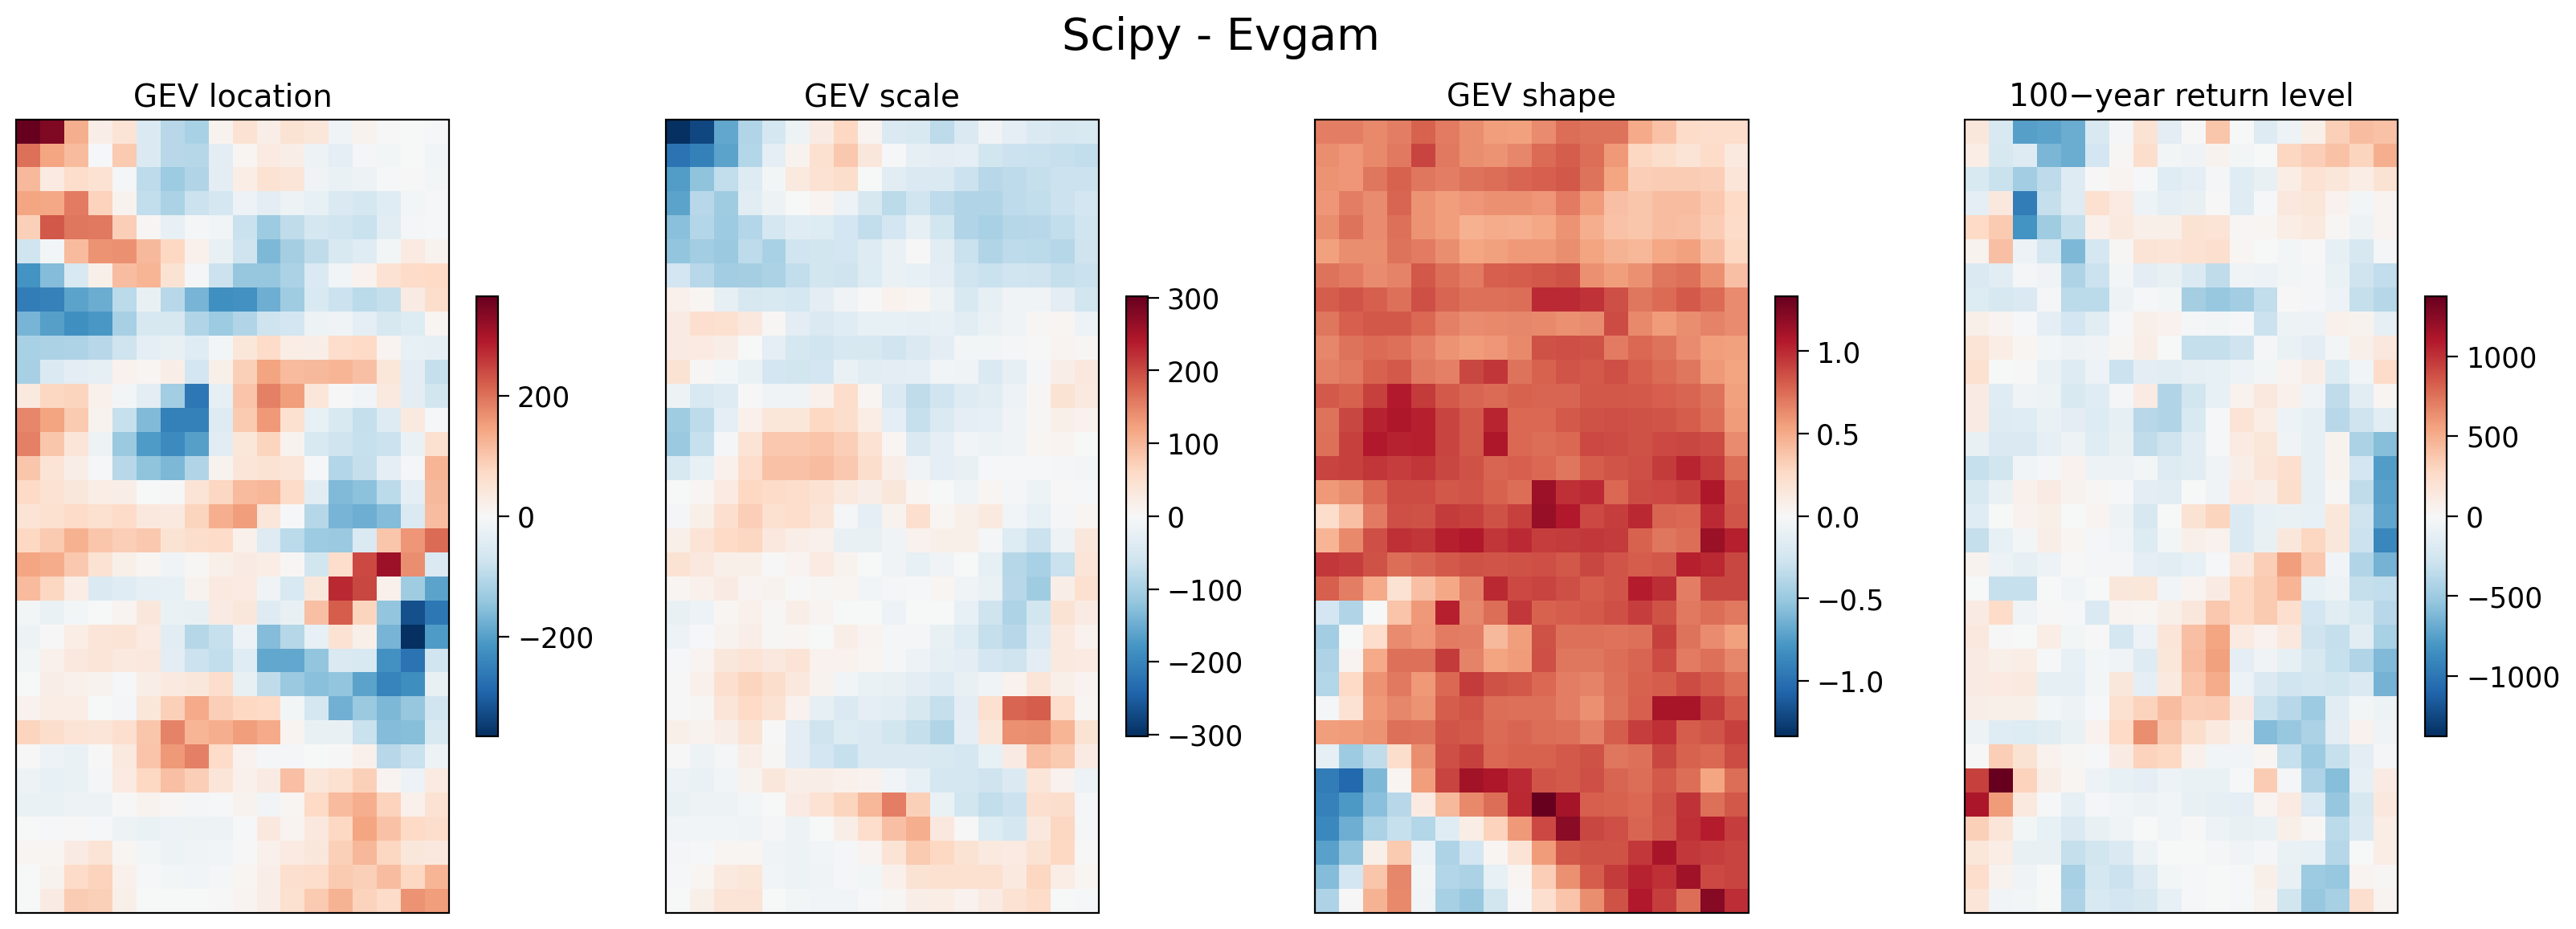

In [41]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,7),subplot_kw={'projection':proj})
plt.subplots_adjust(bottom=0.1,top=0.97)
#
data=(Tlocation-dsgev_pred['location'])
data=data.isel(lon=slice(1,19))
data.plot(ax=ax[0],cbar_kwargs={'label':'','shrink':0.45})
#ax[0].contour(data['lon'],data['lat'],dsmij['air'].isel(lon=slice(1,19)),cmap='gnuplot2')
ax[0].set_title('GEV location',fontsize=14)
#
data=(Tscale-dsgev_pred['scale'])
data=data.isel(lon=slice(1,19))
data.plot(ax=ax[1],cbar_kwargs={'label':'','shrink':0.45})
#ax[1].contour(data['lon'],data['lat'],dsmij['air'].isel(lon=slice(1,19)),cmap='gnuplot2')
ax[1].set_title('GEV scale',fontsize=14)
#
data=(Tshape-dsgev_pred['shape'])
data=data.isel(lon=slice(1,19))
data.plot(ax=ax[2],cbar_kwargs={'label':'','shrink':0.45})
#ax[2].contour(data['lon'],data['lat'],dsmij['air'].isel(lon=slice(1,19)),cmap='gnuplot2')
ax[2].set_title('GEV shape',fontsize=14)
#
data=(Trl100-dsgev_rl100['q:0.99'])
data=data.isel(lon=slice(1,19))
data.plot(ax=ax[3],cbar_kwargs={'label':'','shrink':0.45})
#ax[3].contour(data['lon'],data['lat'],dsmij['air'].isel(lon=slice(1,19)),cmap='gnuplot2')
ax[3].set_title('100−year return level',fontsize=14)
plt.suptitle('Scipy - Evgam',fontsize=20)

GH: Funny enough we can see the Geopotential Height signal in the difference of the 100-year return level computed by Scipy and evgam.